# NDVI Timeseries

This notebook presents an application case that demonstrates how to display the NDVI (Normalized Difference Vegetation Index) timeseries for specific fields. The case study showcases the process of selecting the fields and generating average NDVI timeseries data for analysis and visualization. 

In [2]:
import pandas as pd
import matplotlib.pyplot as pl
import shapely.geometry
import json
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import openeo
from openeo.rest.conversions import timeseries_json_to_pandas

/home/pratixa/.local/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
#connect to the backend and authenticate

connection = openeo.connect(url = "openeo-staging.creo.vito.be").authenticate_oidc()

Authenticated using refresh token.


let's calculate a time series of the average NDVI in a couple of fields in this area.

First, load the fields as shapely geometries:

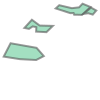

In [4]:
fields_geojson = '{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}, {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}, {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}, {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}]}'
fields = shapely.geometry.shape(json.loads(fields_geojson))
fields

Like before, we load like a data cube and calculate the NDVI, but we now use a larger time window covering of a couple of months.

Also note that we don't have to specify a bounding box explicitly when loading the cube,
because we will pass the desired fields in a next step, 
and the backend will limit the data loading to those areas appropriately.

In [5]:
dates = ("2020-06-01", "2020-10-01")

cube = connection.load_collection("SENTINEL2_L2A", temporal_extent=dates, bands=["B04", "B08", "SCL"])

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

With the `DataCube.aggregate_spatial()` method , we can calculate the mean NDVI for each of the fields.

In [6]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

We trigger execution by downloading the result. 
Because `DataCube.aggregate_spatial()` returns a timeseries (instead of raster data), we download it in JSON format.

In [7]:
timeseries.download("output/timeseries.json", format="JSON")

In [8]:
with open("output/timeseries.json") as f:
    ts = timeseries_json_to_pandas(json.load(f)).dropna()
ts.index = pd.to_datetime(ts.index)
ts.head()

polygon,0,1,2,3
date,,,,
2020-06-01 00:00:00+00:00,0.748476,0.495063,0.655510,0.486538
2020-06-04 00:00:00+00:00,0.028493,0.026855,0.026339,0.026769
2020-06-06 00:00:00+00:00,0.760013,0.501150,0.694817,0.394088
2020-06-09 00:00:00+00:00,0.070291,0.073217,0.062952,0.047764
2020-06-11 00:00:00+00:00,0.024885,0.026817,0.028701,0.026536


In [9]:
# defining the plotting function

import matplotlib.pyplot as plt 
DEFAULT_FIGSIZE = (5, 4)

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    ts.index = pd.to_datetime(ts.index)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); ax.set_ylabel("NDVI");ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

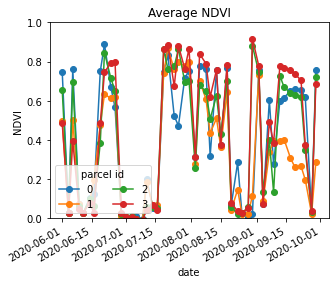

In [10]:
plot_timeseries( "output/timeseries.json")

The result above is a good start, but needs some work: there are quite some outliers and zero's that don't look right.
The reason for this are cloudy observations that cause unusable NDVI values.
We will add some cloud masking to generate a cleaner time series.

First, create a simple gaussian kernel:

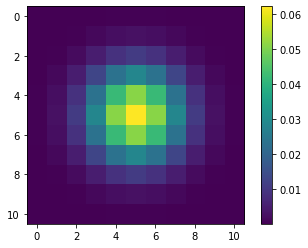

In [11]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im)

In [12]:
classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

masked_ndvi = ndvi.mask(mask)

In [13]:
masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")
masked_timeseries.download("output/timeseries-masked.json", format="JSON")

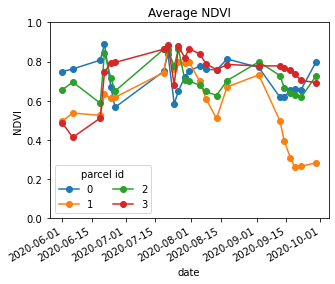

In [14]:
plot_timeseries( "output/timeseries-masked.json")